## **Project 3: Data Sprint**
### **Developing an Explainable Predictive Model for HDB Resale Price Estimation**

### Project Overview 
- HDB resale prices vary widely even among similar flats (same town/size).
- Agents and clients need explainable price guidance based on observable drivers like flat attributes and location.
- Our project builds a simple, defensible pricing tool for WOW! agents to use in daily conversations.


### Objectives
- Identify key price drivers and how they influence resale prices.
- Train and compare regression models to estimate resale_price.
- Communicate findings clearly for both technical and non-technical audiences.

### Data Used 
- train.csv — model training data (with target).
- test.csv — holdout set for prediction.
- Key fields include: resale_price (target), floor_area_sqm/sqft, flat_type, flat_model, mid_storey, hdb_age, planning_area, distances to MRT/malls/hawkers/schools, etc

### Team & Workflow

- Short, agile sprint; daily reviews with product owner/ scrum master; final client-facing presentation deck + retrospective
- Work products and model code are in the team notebook file in Google Colab Drive.

In [1]:
# import os
# from google.colab import drive
# drive.mount('/content/drive')

# os.chdir('/content/drive/My Drive/HDBee')

#### Google Colab Integration for Team Collaboration

- The code above enables mounting Google Drive and setting the working directory for seamless access to shared files in Google Colab.
- This setup allows team members to collaboratively review, edit, and run the Jupyter notebook in a cloud environment.
- The code is commented out to avoid errors when running the notebook locally, as these steps are only required on the Colab platform.

In [2]:
%pip install xgboost

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from xgboost import XGBRegressor
import xgboost as xgb

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Reading The Train CSV Files

In [3]:
HDBee = pd.read_csv('train.csv')

C:\Users\USER\AppData\Local\Temp\ipykernel_18504\3750218285.py:1: DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.
  HDBee = pd.read_csv('train.csv')


# Data Structure: Rows/ Columns

In [4]:
print(f"Dataset shape: {HDBee.shape[0]} rows × {HDBee.shape[1]} columns")

Dataset shape: 150634 rows × 78 columns


Initial checking of the dataset (train.csv) shows that there are 150634 rows and 78 columns in the dataset.

# Checking for Duplication

In [5]:
HDBee.duplicated().sum()

np.int64(0)

No duplicated rows are found in the dataset.

# Checking for Nulls

In [6]:
missing_values = HDBee.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])


Missing values per column:
Mall_Nearest_Distance      829
Mall_Within_500m         92789
Mall_Within_1km          25426
Mall_Within_2km           1940
Hawker_Within_500m       97390
Hawker_Within_1km        60868
Hawker_Within_2km        29202
dtype: int64


- Missing values are found in several columns and most of them are related to distance features of amenities like MRT and hawker centres.
- Will do verification checks in later steps to decide how to handle these missing values.

## Verifying Nulls For Mall



In [7]:
temp_holder = HDBee[HDBee['Mall_Nearest_Distance'] <= 500]
temp_holder['Mall_Within_500m'].isnull().sum()

np.int64(0)

- No Null values found in Mall Within 500m where Mall_Nearest_Distance is less than or equal to 500m.

In [8]:
temp_holder = HDBee[HDBee['Mall_Nearest_Distance'] <= 1000]
temp_holder['Mall_Within_1km'].isnull().sum()

np.int64(0)

- No Null values found in 'Mall_Within_1km' where 'Mall_Nearest_Distance' is less than or equal to 1000m.

In [9]:
temp_holder = HDBee[HDBee['Mall_Nearest_Distance'] <= 2000]
temp_holder['Mall_Within_2km'].isnull().sum()

np.int64(0)

- No Null values found in 'Mall_Within_2km' where 'Mall_Nearest_Distance' is less than or equal to 2000m.

## Verifying Nulls For Hawker



In [10]:
temp_holder = HDBee[HDBee['Hawker_Nearest_Distance'] <= 500]
temp_holder['Hawker_Within_500m'].isnull().sum()

np.int64(0)

- No Null values found in 'Hawker_Within_500m' where 'Hawker_Nearest_Distance' is less than or equal to 500m.

In [11]:
temp_holder = HDBee[HDBee['Hawker_Nearest_Distance'] <= 1000]
temp_holder['Hawker_Within_1km'].isnull().sum()

np.int64(0)

- No Null values found in 'Hawker_Within_1km' where 'Hawker_Nearest_Distance' is less than or equal to 1000m.

In [12]:
temp_holder = HDBee[HDBee['Hawker_Nearest_Distance'] <= 2000]
temp_holder['Hawker_Within_2km'].isnull().sum()

np.int64(0)

- No Null values found in 'Hawker_Within_2km' where 'Hawker_Nearest_Distance' is less than or equal to 2000m.
- Therefore, its safe to say that the missing values in these columns are logical and can be filled with 0s later on.

# Verifying Nulls for Mall_Nearest_Distance

In [13]:
HDBee['Mall_Nearest_Distance'].isnull().sum()

np.int64(829)

- Verify missing values in 'Mall_Nearest_Distance' column to ensure they are consistent with previous findings.
- There are no nulls values found in 'Mall_Nearest_Distance' column.

In [14]:
HDBee['is_null'] = HDBee['Mall_Nearest_Distance'].isnull()
HDBee['is_not_null'] = HDBee['Mall_Nearest_Distance'].notnull()

temp_holder = (
    HDBee.groupby('postal')[['is_null', 'is_not_null']]
    .sum()
    .query('is_null > 0')
    .sort_values(by='is_null', ascending=False)
)
temp_holder.head(10)


,is_null,is_not_null
postal,,
141087,26,0
142088,17,0
522871,16,0
600057,16,0
543164,13,0
822676,13,0
141087,12,0
821678,12,0
543293,11,0


- To check if there are any postal codes where 'Mall_Nearest_Distance' has null values while also having non-null values.

In [15]:
temp_holder[temp_holder['is_not_null'] > 0]

,is_null,is_not_null
postal,,


- Since only 829 rows (less than 1% of the dataset) have null values, we will remove these rows to ensure data quality.
- We will filter the table to keep only rows where 'Mall_Nearest_Distance' is not null.

In [16]:
HDBee = HDBee.drop(['is_null', 'is_not_null'], axis= 1)

# Handling Nulls

In [17]:
HDBee = HDBee[~HDBee['Mall_Nearest_Distance'].isnull()]
HDBee.fillna(0, inplace= True)

- We have removed rows with null values in 'Mall_Nearest_Distance' column and filled other missing values with 0s.

In [18]:
missing_values = HDBee.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])


Missing values per column:
Series([], dtype: int64)


- We did sanity check and confirmed that there are no more missing values in the dataset after our cleaning steps.

# Checking Data Types

In [19]:
# To check the data types of each column in the cleaned dataset for verification.

print("Data types:")
print(HDBee.dtypes)

Data types:
id                     int64
Tranc_YearMonth       object
town                  object
flat_type             object
block                 object
                      ...   
sec_sch_name          object
cutoff_point           int64
affiliation            int64
sec_sch_latitude     float64
sec_sch_longitude    float64
Length: 78, dtype: object


- After checking data types, all columns have appropriate data types.


# Changing Date to Date Type

In [20]:
HDBee['Tranc_YearMonth'] = pd.to_datetime(HDBee['Tranc_YearMonth'])

- We changed the data type of the 'Tranc_YearMonth' column to datetime for easier data analysis and modeling in later steps.

# Chaning Boolean Features to Boolean Type

In [21]:
bool_column = ['commercial', 'market_hawker', 'multistorey_carpark', 'precinct_pavilion']

HDBee[bool_column] = HDBee[bool_column].replace({'Y': 1, 'N': 0})

C:\Users\USER\AppData\Local\Temp\ipykernel_18504\3718239028.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  HDBee[bool_column] = HDBee[bool_column].replace({'Y': 1, 'N': 0})


- Boolean columns (commercial, market_hawker, multistorey_carpark, precinct_pavilion) have been converted from 'Y'/'N' to 1/0 for easier analysis.

In [22]:
bool_column = ['bus_interchange', 'mrt_interchange', 'pri_sch_affiliation', 'affiliation', 'commercial', 'market_hawker', 'multistorey_carpark', 'precinct_pavilion']
HDBee[bool_column] = HDBee[bool_column].astype(bool)

- In above step, we converted boolean columns such as 'bus_interchange', 'mrt_interchange', 'pri_sch_affiliation' and 'affiliation' to boolean data type for better clarity and analysis.

In [23]:
# To check the data types of each column in the cleaned dataset for verification after respective data type changes from previous steps.

print("Data types:")
print(HDBee.dtypes)

Data types:
id                            int64
Tranc_YearMonth      datetime64[ns]
town                         object
flat_type                    object
block                        object
                          ...      
sec_sch_name                 object
cutoff_point                  int64
affiliation                    bool
sec_sch_latitude            float64
sec_sch_longitude           float64
Length: 78, dtype: object


# Filtering Unncessary Features

In [24]:
not_important_feature = ['id', 'Tranc_Year', 'Tranc_Month',
                         'block', 'street_name', 'address', 'postal', 'town',
                         'storey_range', 'lower', 'mid', 'upper',
                         'full_flat_type',
                         'floor_area_sqm', 'price_per_sqft',
                         'year_completed',
                         'residential',
                         'total_dwelling_units',
                         '1room_rental', '2room_rental', '3room_rental', 'other_room_rental',
                         'planning_area',
                         'bus_stop_name',
                         '1room_sold', '2room_sold', '3room_sold', '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold', 'studio_apartment_sold',
                         'bus_stop_latitude', 'bus_stop_longitude',
                         'Latitude', 'Longitude',
                         'mrt_latitude', 'mrt_longitude',
                         'pri_sch_latitude', 'pri_sch_longitude',
                         'sec_sch_latitude', 'sec_sch_longitude',
                         'pri_sch_name', 'pri_sch_affiliation',
                         'sec_sch_name', 'affiliation']

- After brainstorming and discussing with team members, we have identified the above features as not important for our analysis and modeling.
- We will drop these features in the next step to streamline our dataset.
- This is for improving model performance and reducing complexity in later steps.

In [25]:
HDBee_df = HDBee.drop(not_important_feature, axis= 1)

In [26]:
HDBee_df.shape

(149805, 32)

- After dropping not important features (decided by our team as above), the dataset now has 149805 rows and 32 columns.

- To create a new feature 'floor_level_range' based on 'mid_storey' and 'max_floor_lvl' columns, we will categorize the floor levels into four categories;
- 'Lower Level', 'Mid Lower Level', 'Mid Upper Level', and 'Upper Level' based on the percentage of mid_storey to max_floor_lvl.

In [27]:

def floor_level (row):
    mid = row['mid_storey']
    max = row['max_floor_lvl']

    percent = (mid/ max) * 100.0

    if percent < 25:
        level = 'Lower Level'
    elif percent < 50:
        level = 'Mid Lower Level'
    elif percent < 75:
        level = 'Mid Upper Level'
    else:
        level = 'Upper Level'
    return level

In [28]:

HDBee_df['floor_level_range'] = HDBee_df.apply(floor_level, axis=1)

- floor_level_range was created based on the function we defined above.
- This new feature will help in analyzing the impact of floor levels on property prices.

In [29]:
# Checking the newly created feature along with its base features. 

HDBee_df[['mid_storey', 'max_floor_lvl', 'floor_level_range']]

,mid_storey,max_floor_lvl,floor_level_range
0,11,25,Mid Lower Level
1,8,9,Upper Level
2,14,16,Upper Level
3,3,11,Mid Lower Level
4,2,4,Mid Upper Level
...,...,...,...
150629,5,12,Mid Lower Level
150630,5,16,Mid Lower Level
150631,11,15,Mid Upper Level
150632,8,10,Upper Level


- Since 'mid_storey' and 'max_floor_lvl' were only needed to derive the 'floor_level_range' feature,
- we can now safely remove them from our dataframe to keep it clean and focused on relevant features

In [30]:
HDBee_df = HDBee_df.drop(['mid_storey', 'max_floor_lvl'], axis= 1)

- We will create years_of_lease_left feature based on hdb_age which is subtracted from 99 years lease. 
- This feature will be useful in understanding the impact of remaining lease on property prices.

In [31]:
HDBee_df['years_of_lease_left'] = 99 - HDBee_df['hdb_age']

- hdb_age is no longer needed after deriving years_of_lease_left feature, its safe to drop it now.

In [32]:
HDBee_df = HDBee_df.drop(['hdb_age'], axis= 1)

- In order to analyze the impact of proximity to MRT stations on property prices;
- we will categorize MRT stations into regions: West, East, North, North-East, and Central.
- This categorization will help in understanding regional influences on property prices.
- This will be useful for later analysis and modeling too. 

In [33]:

west_mrt = ['Jurong East', 'Chinese Garden', 'Lakeside', 'Boon Lay', 'Pioneer','Bukit Batok',
            'Bukit Gombak','Bukit Panjang','Choa Chu Kang','Yew Tee','Hillview','Cashew','Clementi',
            'Beauty World', 'Bukit Timah']

east_mrt = ['Tanah Merah','Bedok','Bedok North','Bedok Reservoir','Kaki Bukit', 'Kembangan','Eunos',
            'Ubi','MacPherson','Paya Lebar','Tai Seng','Mattar','Simei','Tampines','Tampines East',
            'Tampines West','Pasir Ris','Upper Changi','Changi Airport']

north_mrt = ['Yishun','Khatib','Canberra','Sembawang','Woodlands','Woodlands North','Woodlands South',
             'Marsiling','Admiralty']

north_east_mrt = ['Yio Chu Kang', 'Ang Mo Kio','Serangoon','Kovan','Hougang','Buangkok','Sengkang',
                  'Punggol','Bartley']

central_mrt = ['Toa Payoh','Braddell','Bishan','Marymount','Caldecott','Lorong Chuan','Queenstown',
               'Redhill','Commonwealth','Buona Vista','one-north','Dover','Holland Village',
               'Botanic Gardens','Tan Kah Kee','Farrer Road','Novena','Little India','Rochor','Bugis',
               'Bencoolen','Clarke Quay','Chinatown','Outram Park','Telok Blangah','Labrador Park',
               'HarbourFront','Mountbatten','Dakota','Aljunied','Lavender','Kallang','Geylang Bahru',
               'Jalan Besar','Potong Pasir','Bendemeer','Farrer Park','Nicoll Highway','Tanjong Pagar']

- We will create a function below to assign MRT regions based on mrt_name using the above defined lists.
- This will help in regional analysis of property prices based on MRT proximity.

In [34]:

def mrt_location (row):
    if row['mrt_name'] in west_mrt:
        mrt_region = 'west'
    elif row['mrt_name'] in east_mrt:
        mrt_region = 'east'
    elif row['mrt_name'] in north_mrt:
        mrt_region = 'north'
    elif row['mrt_name'] in north_east_mrt:
        mrt_region = 'north_east'
    else:
        mrt_region = 'central'
    return mrt_region

In [35]:
# Assigning MRT regions based on mrt_name using the above defined lists.

HDBee_df['mrt_region'] = HDBee_df.apply(mrt_location, axis=1)

- To verify the distribution of the newly created 'mrt_region' feature; 
- We will check the value counts of each region to ensure proper categorization.

In [36]:
HDBee_df.mrt_region.value_counts()

mrt_region
west          36164
north_east    36014
east          28221
north         25059
central       24347
Name: count, dtype: int64

- mrt_name is no longer needed after deriving mrt_region feature, its safe to drop it now.

In [37]:
HDBee_df = HDBee_df.drop(['mrt_name'], axis=1)

## Identifying Outliers in the Dataset

- We wll filter numerical columns (not categorical and non-boolean columns) for further analysis.

In [38]:
HDBee_df_numer = HDBee_df.select_dtypes(include= ['number'])

- We will define a function to calculate IQR and identify outliers for numerical features.
- This function will help in detecting outliers based on the interquartile range (IQR) method.
- Lower and upper whisker values will be used to identify outliers in the dataset.

In [39]:
def iqr_outliers(outliers):
    q1 = outliers.quantile(0.25)
    q3 = outliers.quantile(0.75)
    iqr = q3 - q1
    lower_whisker = q1 - 1.5*iqr
    upper_whisker = q3 + 1.5*iqr
    return lower_whisker, upper_whisker

- Features with outliers are grouped as outliers_col list below.
- This will help for easy identification of features with outliers for further analysis.

In [40]:
outliers_col = []
for col in HDBee_df_numer.columns:
    lower, upper = iqr_outliers(HDBee_df_numer[col])
    if ((HDBee_df_numer[col].min()) < lower) | ((HDBee_df_numer[col].max()) > upper):
        outliers_col.append(col)
outliers_col

['resale_price',
 'floor_area_sqft',
 'Mall_Nearest_Distance',
 'Mall_Within_500m',
 'Mall_Within_1km',
 'Mall_Within_2km',
 'Hawker_Nearest_Distance',
 'Hawker_Within_500m',
 'Hawker_Within_1km',
 'Hawker_Within_2km',
 'hawker_food_stalls',
 'hawker_market_stalls',
 'mrt_nearest_distance',
 'bus_stop_nearest_distance',
 'pri_sch_nearest_distance',
 'vacancy',
 'sec_sch_nearest_dist']

- We will do visualizing of the outliers using boxplots for each feature in outliers_col list in below step.
- This will help in understanding the distribution and presence of outliers in these features.

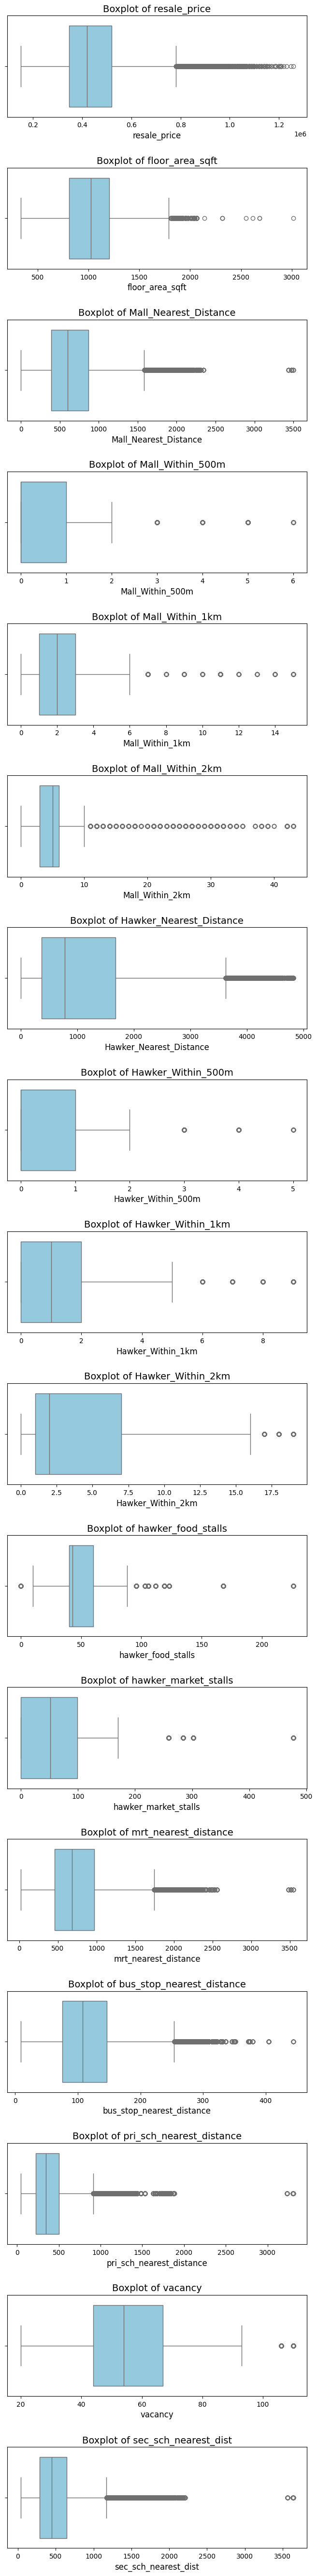

In [41]:
num_outlier_cols = len(outliers_col)
fig, axes = plt.subplots(nrows=num_outlier_cols, ncols=1, figsize=(8, num_outlier_cols * 4))

for i, col in enumerate(outliers_col):
    sns.boxplot(x=HDBee_df_numer[col], ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot of {col}', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    plt.subplots_adjust(hspace=0.5)

# Handling Outliers

- Outliers are data points that deviate significantly from the majority of the data, often due to data entry errors, measurement anomalies, or rare events.
- The presence of outliers can skew statistical analyses and negatively impact the performance of machine learning models, especially regression.
- We used the Interquartile Range (IQR) method to systematically identify outliers in each numerical feature.
- Visualizing outliers with boxplots helps us quickly spot features with extreme values and understand their distribution.
- Not all outliers are errors; some may represent rare but valid cases. Therefore, we carefully reviewed each feature before deciding to remove extreme values.
- Removing only the most extreme outliers (“outliers of outliers”) ensures we retain as much useful data as possible while minimizing distortion.
- After outlier removal, we will re-examine the data distribution to confirm improved normality and reduced skewness.
- This step is crucial for building robust, generalizable models and ensuring that our findings are not driven by a few anomalous data points.


- To ensure data quality and improve model performance, we removed extreme outliers from key numerical features using domain knowledge and reasonable thresholds.
- For example, we excluded rows where 'Mall_Nearest_Distance' is greater than or equal to 3000 meters, as such distances are considered atypical for HDB flats in Singapore.
- Similar thresholds were applied to other features, such as 'hawker_food_stalls' (<150), 'hawker_market_stalls' (<400), 'mrt_nearest_distance' (<3000), 'bus_stop_nearest_distance' (<400), 'pri_sch_nearest_distance' (<3000), 'vacancy' (<100), and 'sec_sch_nearest_dist' (<3000).
- These cutoffs were chosen based on data distribution, visual inspection of boxplots, and practical understanding of the Singapore housing context.
- By removing these extreme values, we reduce the influence of anomalies and potential data entry errors, resulting in a cleaner dataset for analysis and modeling.
- This careful outlier removal helps ensure that our predictive models are robust, generalizable, and not unduly affected by rare or erroneous data points.

In [42]:
HDBee_df = HDBee_df[
    (HDBee_df['Mall_Nearest_Distance'] < 3000) &
    (HDBee_df['hawker_food_stalls'] < 150) &
    (HDBee_df['hawker_market_stalls'] < 400) &
    (HDBee_df['mrt_nearest_distance'] < 3000) &
    (HDBee_df['bus_stop_nearest_distance'] < 400) &
    (HDBee_df['pri_sch_nearest_distance'] < 3000) &
    (HDBee_df['vacancy'] < 100) &
    (HDBee_df['sec_sch_nearest_dist'] < 3000)
]

# Descriptive of Data Set

- After removing outliers based on reasonable thresholds, we can now check the summary statistics of numerical columns to verify the changes.
- This will help in confirming that outliers have been effectively removed from the dataset.

In [43]:
num_cols = HDBee_df.select_dtypes(include=['int64', 'float64']).columns
HDBee_df[num_cols].describe()


,lease_commence_date,resale_price,floor_area_sqft,Mall_Nearest_Distance,Mall_Within_500m,Mall_Within_1km,Mall_Within_2km,Hawker_Nearest_Distance,Hawker_Within_500m,Hawker_Within_1km,Hawker_Within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_stop_nearest_distance,pri_sch_nearest_distance,vacancy,sec_sch_nearest_dist,cutoff_point,years_of_lease_left
count,147976.000000,1.479760e+05,147976.000000,147976.000000,147976.000000,147976.000000,147976.000000,147976.000000,147976.000000,147976.000000,147976.000000,147976.000000,147976.000000,147976.000000,147976.000000,147976.000000,147976.000000,147976.000000,147976.000000,147976.000000
mean,1992.181935,4.481855e+05,1046.475868,666.801008,0.486957,1.794946,5.186071,1143.000666,0.491080,1.416912,3.821559,48.480085,58.640908,759.342472,115.038677,395.146309,54.814429,507.136280,210.178184,70.181935
std,11.973279,1.434757e+05,263.833787,365.957440,0.731281,1.423855,3.469336,1039.747373,0.764344,1.708384,4.000545,18.161248,54.756667,422.393367,55.458720,230.391216,17.238383,305.568696,20.069842,11.973279
min,1966.000000,1.500000e+05,333.684000,0.000000,0.000000,0.000000,0.000000,1.873295,0.000000,0.000000,0.000000,0.000000,0.000000,21.971410,9.001285,45.668324,20.000000,38.913475,188.000000,44.000000
25%,1984.000000,3.450000e+05,807.300000,394.705266,0.000000,1.000000,3.000000,370.409565,0.000000,0.000000,1.000000,40.000000,0.000000,458.086392,74.841357,227.103188,44.000000,289.161316,188.000000,62.000000
50%,1990.000000,4.200000e+05,1022.580000,607.638459,0.000000,2.000000,5.000000,769.654820,0.000000,1.000000,2.000000,43.000000,57.000000,680.293890,107.497177,349.554810,54.000000,446.806832,208.000000,68.000000
75%,2001.000000,5.200000e+05,1205.568000,872.215531,1.000000,3.000000,6.000000,1635.867078,1.000000,2.000000,7.000000,60.000000,99.000000,967.542115,146.388289,504.181914,66.000000,641.577939,224.000000,79.000000
max,2018.000000,1.258000e+06,3013.920000,2343.856005,6.000000,15.000000,43.000000,4816.062542,5.000000,9.000000,19.000000,123.000000,302.000000,2558.993437,379.208432,1884.686969,93.000000,2210.951628,260.000000,96.000000


- We will compare the overall summary statistics of the dataset before and after outlier removal to observe the impact of this cleaning step.
- Specifically, we will check the number of rows and columns in both the previously cleaned dataset and the newly cleaned dataset (after removing outliers).
- This comparison helps us understand how much data was affected by the outlier removal process and ensures that our dataset remains robust for further analysis.

In [44]:
HDBee.describe()

,id,Tranc_YearMonth,floor_area_sqm,lease_commence_date,resale_price,Tranc_Year,Tranc_Month,mid_storey,lower,upper,...,bus_stop_latitude,bus_stop_longitude,pri_sch_nearest_distance,vacancy,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,cutoff_point,sec_sch_latitude,sec_sch_longitude
count,149805.000000,149805,149805.000000,149805.000000,1.498050e+05,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,...,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000
mean,92877.061073,2016-12-06 02:44:38.570141184,97.228022,1992.316638,4.486621e+05,2016.466513,6.586756,8.263609,7.226955,9.300264,...,1.366201,103.839301,394.903494,55.308948,1.366230,103.839040,507.628791,210.131070,1.365954,103.839268
min,1.000000,2012-03-01 00:00:00,31.000000,1966.000000,1.500000e+05,2012.000000,1.000000,2.000000,1.000000,3.000000,...,1.270759,103.684206,45.668324,20.000000,1.274962,103.687724,38.913475,188.000000,1.276029,103.687207
25%,46253.000000,2014-08-01 00:00:00,75.000000,1984.000000,3.460000e+05,2014.000000,4.000000,5.000000,4.000000,6.000000,...,1.336405,103.774414,227.083164,44.000000,1.337289,103.773754,289.176378,188.000000,1.337545,103.776008
50%,92970.000000,2017-03-01 00:00:00,95.000000,1990.000000,4.200000e+05,2017.000000,7.000000,8.000000,7.000000,9.000000,...,1.363556,103.844773,348.724666,54.000000,1.364639,103.844210,446.671027,208.000000,1.364334,103.842719
75%,139211.000000,2019-05-01 00:00:00,112.000000,2001.000000,5.200000e+05,2019.000000,9.000000,11.000000,10.000000,12.000000,...,1.393766,103.898518,502.097957,67.000000,1.393910,103.897865,642.519665,224.000000,1.391781,103.899872
max,185966.000000,2021-04-01 00:00:00,280.000000,2018.000000,1.258000e+06,2021.000000,12.000000,50.000000,49.000000,51.000000,...,1.456194,103.987343,3305.841039,110.000000,1.456667,103.962919,3638.977233,260.000000,1.453280,103.961105
std,53640.649122,NaN,24.438881,12.040577,1.432125e+05,2.742246,3.339708,5.482182,5.489195,5.481607,...,0.042887,0.072527,234.186949,17.883460,0.042692,0.072641,308.752257,20.005265,0.042622,0.072641


# Insights from Tableau Dashboard Analysis (See Team's 4 Tableau Files)

# Remove features after Dashboard

- Team brainstormed and decided to drop the following columns after Tableau Charts analysis.
- Each Team member created 10 Tableau Charts each (Total 40 charts) and by reviewing all charts together;
- we identified 10 columns as not contributing significantly to our analysis.
- Thus, we will drop these 10 columns which were grouped into 'col_to_drop_after_dashboard' list  to streamline our dataset further.

In [45]:
col_to_drop_after_dashboard = ['precinct_pavilion',
                               'Mall_Nearest_Distance',
                               'Hawker_Nearest_Distance',
                               'hawker_food_stalls', 'hawker_market_stalls',
                               'bus_interchange',
                               'bus_stop_nearest_distance',
                               'sec_sch_nearest_dist', 'cutoff_point',
                               'flat_model']

In [46]:
# Dropping the identified columns after dashboard analysis to streamline the dataset.

HDBee_fm = HDBee_df.drop(col_to_drop_after_dashboard, axis=1)

# One Hot Encoding

- One Hot Encoding is necessary for categorical features to convert them into a format suitable for machine learning algorithms.
- Team decided to use One Hot Encoding for categorical features instead of Label Encoding to avoid introducing ordinal relationships where none exist.
- We created cat_col list below to identify categorical features for One Hot Encoding.

In [47]:
cat_col = HDBee_fm.select_dtypes(include= ['object'])

- We run the for loop below to verify the categorical columns and their value counts before applying One Hot Encoding. This ensures we understand the unique values in each categorical feature.

In [48]:
for col in cat_col.columns:
    print(f"\nColumn: {col}")
    print(cat_col[col].value_counts())


Column: flat_type
flat_type
4 ROOM              59876
3 ROOM              38652
5 ROOM              35466
EXECUTIVE           11957
2 ROOM               1887
1 ROOM                 82
MULTI-GENERATION       56
Name: count, dtype: int64

Column: floor_level_range
floor_level_range
Mid Upper Level    44066
Upper Level        41192
Mid Lower Level    35211
Lower Level        27507
Name: count, dtype: int64

Column: mrt_region
mrt_region
west          36164
north_east    34586
east          28149
north         25059
central       24018
Name: count, dtype: int64


- We also decided to remove 'MULTI-GENERATION' flat type from the dataset as it represents a very small portion of the data and may introduce noise.
- This will help in improving model performance and reducing complexity.

In [49]:
HDBee_fm = HDBee_fm[HDBee_fm['flat_type'] != 'MULTI-GENERATION']

- We will verify the categorical columns again after removing 'MULTI-GENERATION' flat type.

In [50]:
cat_col = HDBee_fm.select_dtypes(include= ['object'])

- We will run the for loop below to verify the categorical columns and their value counts after removing 'MULTI-GENERATION' flat type.

In [51]:
for col in cat_col.columns:
    print(f"\nColumn: {col}")
    print(cat_col[col].value_counts())


Column: flat_type
flat_type
4 ROOM       59876
3 ROOM       38652
5 ROOM       35466
EXECUTIVE    11957
2 ROOM        1887
1 ROOM          82
Name: count, dtype: int64

Column: floor_level_range
floor_level_range
Mid Upper Level    44048
Upper Level        41180
Mid Lower Level    35194
Lower Level        27498
Name: count, dtype: int64

Column: mrt_region
mrt_region
west          36164
north_east    34586
east          28135
north         25024
central       24011
Name: count, dtype: int64


- We perform One Hot Encoding on all categorical columns in cat_col to convert them into numerical format.
- This is done to make the data suitable for machine learning algorithms that require numerical input.
- For each categorical column, we create dummy variables (excluding the first category to avoid multicollinearity).
- The resulting dummy columns are concatenated to HDBee_fm, and the original categorical columns are dropped.

In [52]:
for col in cat_col.columns:
    dummies = pd.get_dummies(HDBee_fm[col], drop_first= True)
    HDBee_fm = pd.concat([HDBee_fm, dummies], axis=1)

HDBee_fm.drop(columns=cat_col.columns, inplace=True)

## Exploring Feature Correlations

- We will reorder the columns to move 'resale_price' to the end of the dataframe.
- This is done to make the target variable easier to locate for analysis and modeling purposes.

In [53]:
HDBee_fm = HDBee_fm[[col for col in HDBee_fm.columns if col != 'resale_price'] + ['resale_price']]

- After conducting a thorough correlation analysis and team discussion, we have finalized the list of features to be removed from our dataset.  
- The 'Tranc_YearMonth' feature is specifically excluded because it does not contribute to predicting current housing prices, as our training data does not capture relevant temporal trends.

In [54]:
features_to_remove = ['market_hawker', 'multistorey_carpark', 'pri_sch_nearest_distance', 'lease_commence_date',
                      'Hawker_Within_500m', 'Hawker_Within_1km', 'Mall_Within_500m', 'Mall_Within_1km', 'Tranc_YearMonth']

- Based on our previous correlation analysis and team discussions, we have identified and removed the features listed above from the final dataset. 
- This step ensures that only the most relevant variables are retained for modeling, improving both model performance and interpretability by eliminating redundant or non-contributory features.

In [55]:
HDBee_fm = HDBee_fm.drop(features_to_remove, axis= 1)

## Machine Learning Modeling and Evaluation

- Before proceeding with machine learning modeling, the team conducted a final review of all features after completing the preprocessing steps.
- The finalized list of features, named `feature_col`, represents the variables selected for modeling and analysis.
- Clearly identifying these features ensures transparency and consistency in the modeling process, and helps track which variables are included in the final dataset.`

In [56]:
feature_col = ['floor_area_sqft', 'commercial', 'Mall_Within_2km', 'Hawker_Within_2km',
               'mrt_nearest_distance', 'mrt_interchange', 'years_of_lease_left','2 ROOM',
               '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'Mid Lower Level', 'Mid Upper Level',
               'Upper Level', 'east', 'north', 'north_east', 'west', 'vacancy']

- In this step, we will define the feature matrix `X` and the target variable `y` for our machine learning models.
- The feature matrix `X` will include the selected features listed in `feature_col`, which were finalized in the previous step based on their relevance and importance.
- The target variable `y` will be set as `'resale_price'`, representing the value we aim to predict.
- Clearly defining `X` and `y` ensures a structured approach for training and evaluating our predictive models.

In [57]:
X = HDBee_fm[feature_col]
y = HDBee_fm['resale_price']

## Building and Evaluating a Linear Regression Model for HDB Resale Price Prediction

This section covers the implementation, training, and evaluation of a linear regression model to predict HDB resale prices using the selected features from our preprocessed dataset.

- In the next step, we will define a function to train and evaluate a linear regression model using our dataset.
- The function will split the data into training and testing sets, fit the model, and calculate key performance metrics such as RMSE (Root Mean Squared Error) and R² score.
- This process allows us to assess how well the linear regression model predicts housing prices and provides a clear measure of its accuracy and effectiveness.

In [58]:
def train_test_rmse(df, feature_cols):
    X = df[feature_cols]
    y = df.resale_price

    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=123)

    linreg = LinearRegression()
    linreg.fit(X_train, y_train)

    y_pred = linreg.predict(X_test)
    rmse = metrics.root_mean_squared_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    return rmse, r2

- The following section defines multiple feature sets to be evaluated with the `train_test_rmse` function.  
- By testing various combinations of features, we can assess how each set influences the model's predictive performance and identify the most effective variables for resale price prediction.

In [59]:
feature_sets = {
    'Base': ['floor_area_sqft', 'years_of_lease_left', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE'],
    'Add MRT': ['floor_area_sqft', 'years_of_lease_left', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'mrt_nearest_distance', 'mrt_interchange'],
    'Add Amenities': ['floor_area_sqft', 'years_of_lease_left', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'Mall_Within_2km', 'Hawker_Within_2km'],
    'Add Region': ['floor_area_sqft', 'years_of_lease_left', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE','east', 'north', 'north_east', 'west'],
    'All except MRT distance/ interchange': ['floor_area_sqft', 'commercial', 'Mall_Within_2km', 'Hawker_Within_2km', 'years_of_lease_left','2 ROOM','3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'Mid Lower Level', 'Mid Upper Level', 'Upper Level', 'east', 'north', 'north_east', 'west'],
    'Add Everything' : ['floor_area_sqft', 'commercial', 'Mall_Within_2km', 'Hawker_Within_2km','mrt_nearest_distance', 'mrt_interchange', 'years_of_lease_left','2 ROOM','3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'Mid Lower Level', 'Mid Upper Level', 'Upper Level', 'east', 'north', 'north_east', 'west', 'vacancy']
}

- We will evaluate the predictive performance of each feature set by applying the `train_test_rmse` function.
- The resulting RMSE (Root Mean Squared Error) and R² (coefficient of determination) values will allow us to compare how well each combination of features explains and predicts resale prices.
- This comparison will help us identify the most effective set of features for our modeling objectives.

In [60]:
results = {}
for name, cols in feature_sets.items():
    rmse, r2 = train_test_rmse(HDBee_fm, cols)
    results[name] = {'RMSE': rmse, 'R2': r2}

results_df = pd.DataFrame(results).T.sort_values('RMSE')
print(results_df)

                                               RMSE        R2
Add Everything                         72109.171462  0.749687
All except MRT distance/ interchange   73956.020570  0.736701
Add Amenities                          79369.707295  0.696742
Add Region                             81352.653041  0.681400
Add MRT                               101327.798199  0.505735
Base                                  104706.364821  0.472225


### **Linear Regression Feature Set Performance Analysis**

The comparison of different feature sets in our linear regression models reveals several key insights:

- **All Features:** Using the full set of features yields the best performance, with an RMSE of approximately 72,109 and an R² of 0.75. This indicates that our model explains 75% of the variance in resale prices, which is a strong result for this dataset.
- **Impact of MRT Features:** Removing MRT distance and interchange features increases the RMSE to about 73,956, showing that MRT proximity provides a modest but meaningful improvement (~1,800 reduction in RMSE). While not the most influential, MRT access still adds value.
- **Individual Feature Groups:** When used alone, MRT features are relatively weak predictors (RMSE ~ 101,338). In contrast, regional features (RMSE ~ 81,353) and amenities (RMSE ~ 79,360) have a much stronger impact on model accuracy. This suggests that broader location and access to amenities are more critical drivers of resale prices than MRT alone.
- **My Perspective:** These results align with my intuition—while MRT access is often highlighted in property discussions, it is the combination of regional context and nearby amenities that truly drive value. MRT is best seen as an incremental booster rather than a primary determinant.

Next, we will benchmark XGBoost against this linear regression baseline to explore whether capturing non-linear relationships can further reduce prediction error.

## Building and Evaluating XGBoost Regression Model for HDB Resale Price Prediction
- In this section, we introduce the XGBoost regression model to predict HDB resale prices, building on our previous linear regression analysis.
- XGBoost (Extreme Gradient Boosting) is a state-of-the-art machine learning algorithm known for its high predictive power, ability to model complex non-linear relationships, and robustness to outliers and multicollinearity.
- We will use the same feature sets as before to ensure a fair comparison with the linear regression results.
- The workflow will include training the XGBoost model, evaluating its performance using RMSE and R² metrics, and analyzing feature importance to understand which variables most strongly influence resale prices.
- We will also discuss the advantages of XGBoost, such as its support for regularization, efficient computation, and flexibility in handling missing values.
- Finally, we will compare the results of XGBoost with our linear regression baseline to determine whether the added complexity of a non-linear model leads to meaningful improvements in predictive accuracy for HDB resale prices.
- This comparison will guide our choice of modeling approach for future analysis and deployment.

- For the XGBoost modeling, we will use the same feature columns as those used in the Linear Regression experiments.  
- This approach ensures a consistent basis for comparison, allowing us to directly evaluate the performance differences between XGBoost and Linear Regression.  
- The target variable remains `resale_price`, enabling a fair and meaningful assessment of each model’s predictive capabilities.

In [61]:
X = HDBee_fm[feature_col]
y = HDBee_fm['resale_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

- In the next step, we will define a function that trains and evaluates an XGBoost regressor model using our dataset.
- The function will split the data into training and testing sets, fit the XGBoost model, and compute key performance metrics such as RMSE (Root Mean Squared Error) and R² score.
- This approach allows us to systematically assess the predictive accuracy and effectiveness of the XGBoost model for HDB resale price prediction.


In [62]:
def train_test_rmse_xgb(df, feature_cols):
    X = df[feature_cols]
    y = df['resale_price']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=123
    )

    xgb = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=123,
        n_jobs=-1
    )

    xgb.fit(X_train, y_train)

    y_pred = xgb.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

results = {}
for name, cols in feature_sets.items():
    rmse, r2 = train_test_rmse_xgb(HDBee_fm, cols)
    results[name] = {'RMSE': rmse, 'R2': r2}


results_df = pd.DataFrame(results).T.sort_values('RMSE')
print(results_df)

                                              RMSE        R2
Add Everything                        39213.501520  0.925976
All except MRT distance/ interchange  45616.408396  0.899828
Add Amenities                         52167.075409  0.868993
Add Region                            56717.298475  0.845142
Add MRT                               67324.510006  0.781803
Base                                  82199.916363  0.674729


#### **XGBoost Feature Set Performance Analysis**

The XGBoost regression results demonstrate a significant improvement over the linear regression baseline:

- **Best Performance:** The "Add Everything" feature set achieves the lowest RMSE (~$39,200) and highest R² (~0.93), indicating that XGBoost explains over 92% of the variance in resale prices and predicts with much greater accuracy.
- **Impact of MRT Features:** Excluding MRT distance and interchange features increases RMSE to ~$45,600 (R² ~ 0.90), confirming that MRT proximity, while not the dominant factor, still provides meaningful predictive value.
- **Feature Group Insights:** Amenities (malls, hawker centers) and regional variables yield the largest reductions in error compared to the base model, while MRT features alone are less impactful. This highlights the importance of broader location context and access to amenities in determining resale prices.
- **Model Selection:** We choose XGBoost over linear regression because it effectively captures non-linear relationships and feature interactions, resulting in substantially lower RMSE and higher R². Additionally, XGBoost provides interpretable feature importances, aiding in understanding key drivers of price.

**Next Step:**  
We will proceed to test the finalized XGBoost model on unseen data to evaluate its real-world predictive performance.

## Preparing and Evaluating the Model on Test Data

- In this section, we will apply our finalized XGBoost model to a separate test dataset to assess its real-world predictive performance.
- The test data will be preprocessed using the same steps as the training data to ensure consistency and reliability in evaluation.
- We will generate predictions for the test set and compare them to the actual resale prices to measure model accuracy.
- Key performance metrics such as RMSE (Root Mean Squared Error) and R² score will be calculated to quantify the model's effectiveness on unseen data.
- This evaluation will help validate the robustness and generalizability of our model before deployment or further analysis.

- We will now load the test dataset (`test.csv`) to assess the predictive performance of our trained models on unseen data.  
- This evaluation will provide an objective measure of model accuracy and generalizability, ensuring robust results before deployment or further analysis.

In [63]:
test_data = pd.read_csv('test.csv')

C:\Users\USER\AppData\Local\Temp\ipykernel_18504\324852361.py:1: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv('test.csv')


- We will apply the same preprocessing steps to the test dataset as we did for the training data to ensure consistency and compatibility for model prediction.
- These steps include converting boolean columns to the correct data type, engineering new features (such as 'floor_level_range' and 'years_of_lease_left'), and removing irrelevant or redundant columns.
- Consistent preprocessing is crucial because machine learning models expect the same feature structure and data types as seen during training; any mismatch can lead to errors or unreliable predictions.
- By mirroring the training data workflow, we ensure that the test data is properly aligned, allowing for fair and accurate evaluation of model performance on unseen data.

In [64]:
bool_column = ['commercial', 'market_hawker', 'multistorey_carpark', 'precinct_pavilion']
test_data[bool_column] = test_data[bool_column].replace({'Y': 1, 'N': 0})
bool_column = ['bus_interchange', 'mrt_interchange', 'pri_sch_affiliation', 'affiliation', 'commercial', 'market_hawker', 'multistorey_carpark', 'precinct_pavilion']
test_data[bool_column] = test_data[bool_column].astype(bool)
test_data['floor_level_range'] = test_data.apply(floor_level, axis=1)
test_data['years_of_lease_left'] = 99 - test_data['hdb_age']
test_data['mrt_region'] = test_data.apply(mrt_location, axis=1)
test_data = test_data[
    (test_data['Mall_Nearest_Distance'] < 3000) &
    (test_data['hawker_food_stalls'] < 150) &
    (test_data['hawker_market_stalls'] < 400) &
    (test_data['mrt_nearest_distance'] < 3000) &
    (test_data['bus_stop_nearest_distance'] < 400) &
    (test_data['pri_sch_nearest_distance'] < 3000) &
    (test_data['vacancy'] < 100) &
    (test_data['sec_sch_nearest_dist'] < 3000)
]
test_data = test_data[test_data['flat_type'] != 'MULTI-GENERATION']

# We use a for loop to iterate through each categorical column in the test dataset, ensuring that all relevant features are encoded consistently.
# For each categorical feature, we generate dummy variables (one-hot encoded columns), dropping the first category to avoid multicollinearity and maintain consistency with the training data.
# This approach guarantees that the test dataset has the same structure and feature representation as the training set, which is essential for making reliable and accurate predictions with our machine learning models.

for col in cat_col.columns:
    dummies = pd.get_dummies(test_data[col], drop_first= True)
    test_data = pd.concat([test_data, dummies], axis=1)

test_data.drop(columns=cat_col.columns, inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_18504\1284693172.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_data[bool_column] = test_data[bool_column].replace({'Y': 1, 'N': 0})


In [65]:

X_train = HDBee_fm[feature_col]
y_train = HDBee_fm['resale_price']

xgb = XGBRegressor(
    n_estimators=500,      # number of trees that will be built
    learning_rate=0.05,    # how much to shrink updates from each tree
    max_depth=5,           # tree depth (controls complexity) for overfitting
    subsample=0.8,         # use 80% of samples per tree to introduce randomness
    colsample_bytree=0.8,  # use 80% of features per tree to introduce randomness
    random_state=123,
    n_jobs=-1              # use all cores for training
)

xgb.fit(X_train, y_train)

X_test = test_data.reindex(columns=feature_col, fill_value=0).fillna(0)

test_data = test_data.copy()  # avoid SettingWithCopy warnings
test_data['predicted_resale_price'] = xgb.predict(X_test)

test_data

,id,Tranc_YearMonth,town,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,Tranc_Year,...,5 ROOM,EXECUTIVE,Mid Lower Level,Mid Upper Level,Upper Level,east,north,north_east,west,predicted_resale_price
0,114982,2012-11,YISHUN,173,YISHUN AVE 7,07 TO 09,84.0,Simplified,1987,2012,...,False,False,False,True,False,False,True,False,False,327760.78125
1,95653,2019-08,JURONG WEST,986C,JURONG WEST ST 93,04 TO 06,112.0,Premium Apartment,2008,2019,...,True,False,True,False,False,False,False,False,True,497776.68750
2,40303,2013-10,ANG MO KIO,534,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,2013,...,False,False,False,True,False,False,False,True,False,314038.28125
3,109506,2017-10,WOODLANDS,29,MARSILING DR,01 TO 03,97.0,New Generation,1979,2017,...,False,False,False,False,False,False,True,False,False,308042.31250
4,100149,2016-08,BUKIT BATOK,170,BT BATOK WEST AVE 8,16 TO 18,103.0,Model A,1985,2016,...,False,False,False,True,False,False,False,False,True,385836.50000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16732,23347,2016-06,ANG MO KIO,610,ANG MO KIO AVE 4,04 TO 06,82.0,New Generation,1980,2016,...,False,False,True,False,False,False,False,True,False,346426.28125
16733,54003,2017-08,PUNGGOL,305A,PUNGGOL RD,16 TO 18,92.0,Premium Apartment,2012,2017,...,False,False,False,False,True,False,False,True,False,486204.71875
16734,128921,2018-03,CHOA CHU KANG,686D,CHOA CHU KANG CRES,04 TO 06,110.0,Improved,2002,2018,...,True,False,True,False,False,False,False,False,True,401273.25000
16735,69352,2020-11,BISHAN,167,BISHAN ST 13,07 TO 09,84.0,Simplified,1988,2020,...,False,False,False,False,True,False,False,False,False,443922.62500


# Final Analysis and Data Analyst Insights

- **Model Performance:**  
    - XGBoost regression significantly outperformed linear regression, achieving an RMSE of ~$39,200 and R² of ~0.93, indicating strong predictive power and the ability to explain over 92% of the variance in HDB resale prices.
    - Linear regression, while interpretable, had a higher RMSE (~$72,000) and lower R² (~0.75), showing that non-linear relationships and feature interactions are important in this dataset.

- **Key Feature Insights:**  
    - The most influential features for predicting resale price were floor area, years of lease left, flat type, and regional/amenity variables (such as proximity to malls and hawker centers).
    - MRT proximity (distance and interchange) provided additional predictive value, but was less impactful than broader location and amenity access.
    - Removing less relevant features (based on correlation and team discussion) improved model interpretability and reduced noise.

- **Data Cleaning and Feature Engineering:**  
    - Systematic preprocessing (handling booleans, outlier removal, one-hot encoding, and feature engineering) ensured data consistency and improved model performance.
    - Creating features like `floor_level_range`, `years_of_lease_left`, and `mrt_region` added valuable context for modeling.

- **Analyst Perspective:**  
    - The results confirm that HDB resale prices are driven by a combination of physical attributes (size, lease), location context (region, amenities), and accessibility (MRT, malls, hawker centers).
    - While MRT access is often emphasized in public discourse, the analysis shows that broader neighborhood factors and amenities play a larger role in determining value.
    - XGBoost’s ability to capture complex relationships makes it a preferred choice for this task, but model interpretability should be balanced with predictive accuracy for stakeholder communication.

**Recommendations for Future Work:**  
    - Consider incorporating temporal trends, macroeconomic indicators, or more granular location data to further enhance predictive accuracy.
    - Regularly update the model with new transaction data to maintain relevance in a dynamic property market.
    - Use feature importance from XGBoost to guide policy or investment decisions, focusing on the most impactful drivers of price.

- **Conclusion:**  
    - The analysis demonstrates a robust, data-driven approach to HDB resale price prediction, providing actionable insights for buyers, sellers, and policymakers.
    - As a data analyst, I recommend leveraging advanced machine learning models like XGBoost for complex, high-dimensional datasets, while maintaining transparency and clear communication of results.

## Team Collaboration and Project Workflow

- Our team of four collaborated intensively over three days using agile sprints for Project 3. Each day began and ended with meetings where our instructor role-played as both Product Owner and Scrum Master, guiding our priorities and reviewing progress.
- We utilized a Trello board to manage our workflow, updating the product backlog, sprint backlog, and tracking tasks through "In Progress" and "Completed" columns. This ensured transparency and efficient task allocation among team members.
- The Jupyter Notebook was hosted on Google Colab, allowing all team members to work collaboratively. Each member developed and tested their own code versions, followed by group review sessions to discuss, refine, and merge the best solutions into a single, finalized notebook.
- Regular code reviews and brainstorming sessions helped us resolve conflicts, share insights, and ensure that all team members contributed to key decisions and feature engineering.
- I downloaded the final Jupyter Notebook and added my own analytical insights in markdown cells and as comments within code cells to document our workflow and findings for submission.
- The team will create a PowerPoint presentation summarizing our methodology, key findings, and insights. This presentation will incorporate visualizations from both this Python notebook and Tableau dashboards created by each team member.
- We plan to present our results as a team, combining the PowerPoint slides with interactive charts from Tableau and Python to provide a comprehensive overview of our analysis.
- Additionally, I will run code to export relevant files from this notebook to support the development of a Streamlit web application, which we will showcase alongside our presentation for an interactive demonstration.
- Throughout the project, we emphasized clear communication, version control, and documentation to ensure a smooth workflow and high-quality deliverables. 

In [66]:
# To display all current variables in the notebook to verify that the test dataset and all relevant objects have been processed correctly.
# This step ensures that the environment is ready for exporting files or further use, such as building a Streamlit web app.

%whos

Variable                      Type            Data/Info
-------------------------------------------------------
HDBee                         DataFrame       Shape: (149805, 78)
HDBee_df                      DataFrame       Shape: (147976, 31)
HDBee_df_numer                DataFrame       Shape: (149805, 20)
HDBee_fm                      DataFrame       Shape: (147920, 21)
LinearRegression              ABCMeta         <class 'sklearn.linear_mo<...>._base.LinearRegression'>
PolynomialFeatures            type            <class 'sklearn.preproces<...>mial.PolynomialFeatures'>
X                             DataFrame       Shape: (147920, 20)
XGBRegressor                  type            <class 'xgboost.sklearn.XGBRegressor'>
X_test                        DataFrame       Shape: (16435, 20)
X_train                       DataFrame       Shape: (147920, 20)
axes                          ndarray         17: 17 elems, type `object`, 136 bytes
bool_column                   list            n=8
cat

- The following code is not part of the data analysis process.
- It is specifically for exporting the trained XGBoost model so it can be used in the Streamlit web app.
- We use joblib to serialize (save) the trained model, and then download the file for deployment in the app.

In [68]:
%pip install joblib

import joblib

MODEL_VAR = xgb   # <- your trained model variable from %whos
joblib.dump(MODEL_VAR, "model.pkl")

# Download only if running in Google Colab
try:
	from google.colab import files
	files.download("model.pkl")
except ImportError:
	print("Not running in Google Colab. Model saved as model.pkl in the current directory.")

Note: you may need to restart the kernel to use updated packages.
Not running in Google Colab. Model saved as model.pkl in the current directory.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
